In [1]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
import analysis_kit as ak
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def squareit(n):
    return n*n

In [3]:
squareit(5)

25

In [4]:
widgets.interact(squareit, n=(0,100))

interactive(children=(IntSlider(value=50, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.squareit>

### ------------------------------------------------------------------------------------------------------------------------------------------------------

### GBM interactive plots

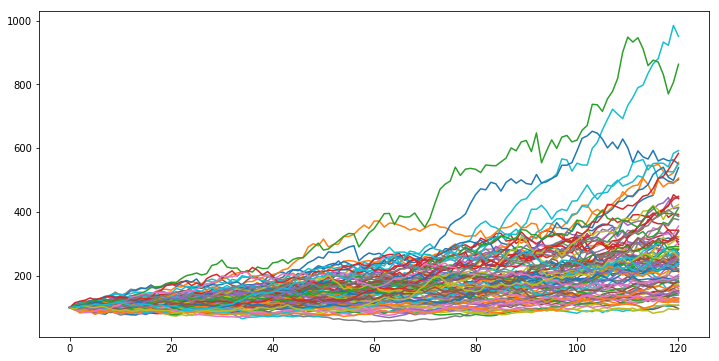

In [5]:
ak.gbm(10,100, 0.1).plot(figsize=(12,6), legend=False) # As you can see, this is a static plot

#### If you would like to interactively understand how changeing the mu affects the return distribution, use ipywidgets

In [6]:
# So, lets first write a function

def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion Model
    """
    s_0=100
    prices=ak.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax=prices.plot(legend=False, figsize=(12,6), color="indianred",alpha=0.5, linewidth=2) # alpha is the transparency of the line
    ax.axhline(y=s_0, ls=":", color="black")
    ax.set_ylim(top=400) # Fixes the maximum value of y-axis to 400
    
    # draw a dot at origin
    
    ax.plot(0,s_0, marker="o",color="darkred", alpha=0.2)
    ax.margins(x=0)

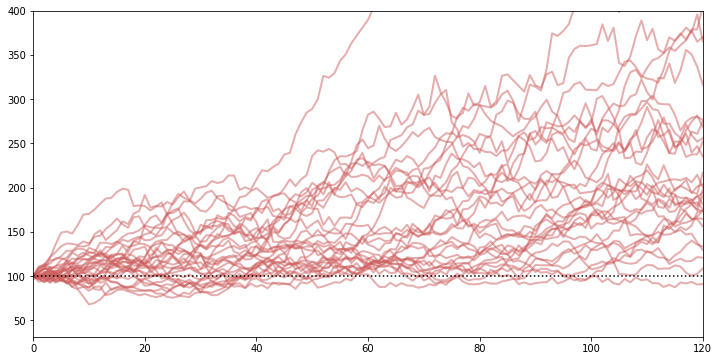

In [7]:
show_gbm(30, 0.07, 0.15)

#### Interactive time

In [8]:
gbm_controls=widgets.interactive(show_gbm,
                                n_scenarios=(1,20,1), ## creating a tuple which as min, max and step size
                                mu= (-0.20,0.2,0.01),
                                sigma=(0,0.3,0.01)
                                ) 

In [9]:
display(gbm_controls)

interactive(children=(IntSlider(value=10, description='n_scenarios', max=20, min=1), FloatSlider(value=0.0, description='mu', max=0.2, min=-0.2, step=0.01), FloatSlider(value=0.15, description='sigma', max=0.3, step=0.01), Output()), _dom_classes=('widget-interact',))

### Interactive CPPI Simulation- Monte Carlo

In [10]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0.,rf_rate=0.03, y_max=100):
    """
    Plot the results of Monte Carlo Simulation of CPPI
    """
    
    start=100
    sim_rets=ak.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma,prices=False, steps_per_year=12)
    risky_r=pd.DataFrame(sim_rets)
    
    # run the back-test

    btr=ak.run_cppi(risky_r=pd.DataFrame(risky_r), rf_rate=rf_rate, m=m, start=start, floor=floor)
    wealth=btr["Wealth"]
    y_max=wealth.values.max()* y_max/100 # y_max is 100 to begin with
    
    ax=wealth.plot(legend=False, figsize=(12,6), alpha=0.3, color="indianred")
    ax.axhline(y=start, ls=":", color="black")
    ax.axhline(y=start*floor, ls="--", color="red")
    ax.set_ylim(top=y_max)
    ax.margins(x=0)   

cppi_controls=widgets.interactive(show_cppi, 
                                 n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                 mu=(0., +.2, .01),
                                 sigma=(0, 0.30, 0.05),
                                 floor=(0,2,0.1),
                                 m=(1,5,0.5),
                                 rf_rate=(0, 0.05, 0.01),
                                 y_max=widgets.IntSlider(min=0, max=100, step=1, value=100, description="Zoom Y Axis"))

display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(value=0.07, description='mu', max=0.2, step=0.01), FloatSlider(value=0.15, description='sigma', max=0.3, step=0.05), FloatSlider(value=3.0, description='m', max=5.0, min=1.0, step=0.5), FloatSlider(value=0.0, description='floor', max=2.0), FloatSlider(value=0.03, description='rf_rate', max=0.05, step=0.01), IntSlider(value=100, description='Zoom Y Axis'), Output()), _dom_classes=('widget-interact',))

### Lets add a histogram that aligns and varys with the cppi simulation

In [23]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0.,rf_rate=0.03, y_max=100, steps_per_year=12):
    """
    Plot the results of Monte Carlo Simulation of CPPI
    """
    
    start=100
    sim_rets=ak.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma,prices=False, steps_per_year=12)
    risky_r=pd.DataFrame(sim_rets)
    
    # run the back-test

    btr=ak.run_cppi(risky_r=pd.DataFrame(risky_r), rf_rate=rf_rate, m=m, start=start, floor=floor)
    wealth=btr["Wealth"]
    y_max=wealth.values.max()* y_max/100 # y_max is 100 to begin with
    terminal_wealth=wealth.iloc[-1]
    
    # Since we know that along with time, there can be many violations of the floor, we want to have some stats readily available
    
    tw_mean=terminal_wealth.mean()
    tw_median=terminal_wealth.median()
    failure_mask=np.less(terminal_wealth, start*floor) # np.less is just a numpy function which returns an array of boolean.
                                                # More specifically, it returns "True" if the terminal wealth < floor value
                                                # and "False" otherwise
    n_failures=failure_mask.sum() # Bascially, counting the number of "True" which is equivalent to counting all 
                                # the 1s in an array
    p_failures=n_failures/n_scenarios
    
    e_shortfall= np.dot(terminal_wealth-(start*floor), failure_mask)/n_failures if n_failures > 0 else 0.0

            # When there is a failure, to what extent does it fail? IOW, the average failure extent! 
            # For eg, you end up at 84 and the floor is 80, its not a problem
            # But if you end up at 75, then you are 5 below the floor

    #Lets plot 
    (fig, (wealth_ax, hist_ax))=plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={"width_ratios":[3,2]}, figsize=(30,12))
    plt.subplots_adjust(wspace=0.0)
    
    
    wealth.plot(ax=wealth_ax, legend=False, figsize=(12,6), alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    wealth_ax.margins(x=0)   
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec="w", fc="indianred",orientation="horizontal") # ec=edge color
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean:${int(tw_mean)}",xy=(0.7,0.9), xycoords="axes fraction", fontsize=12)
    hist_ax.annotate(f"Median:${int(tw_median)}", xy=(0.7, 0.85), xycoords="axes fraction", fontsize=12)
    if(floor>0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"violations:{n_failures}({p_failures*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", 
                        xy=(0.7, 0.7), xycoords="axes fraction", fontsize=12) # examples of f-string
        
    

cppi_controls=widgets.interactive(show_cppi, 
                                 n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                 mu=(0., +.2, .01),
                                 sigma=(0, 0.30, 0.05),
                                 floor=(0,2,0.1),
                                 m=(1,5,0.5),
                                 rf_rate=(0, 0.05, 0.01),
                                 y_max=widgets.IntSlider(min=0, max=100, step=1, value=100, description="Zoom Y Axis"),
                                 steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12, description="Rebals/Year"))

display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(value=0.07, description='mu', max=0.2, step=0.01), FloatSlider(value=0.15, description='sigma', max=0.3, step=0.05), FloatSlider(value=3.0, description='m', max=5.0, min=1.0, step=0.5), FloatSlider(value=0.0, description='floor', max=2.0), FloatSlider(value=0.03, description='rf_rate', max=0.05, step=0.01), IntSlider(value=100, description='Zoom Y Axis'), IntSlider(value=12, description='Rebals/Year', max=12, min=1), Output()), _dom_classes=('widget-interact',))